In [1]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import acquire_PJ
import wrangle_PJ
import acquire
from scipy import stats
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

np.random.seed(123)

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
zillow = acquire.get_zillow_data()

In [3]:
# Get a peek of the dataframe
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [4]:
# Create a function that will remove rows and columns that have missing values past a certain threshold.
def handle_missing_values(df, p_row = 0.84, p_col = 0.84):
    ''' function which takes in a dataframe, required notnull proportions of non-null rows and columns.
    drop the columns and rows columns based on theshold:'''
    
    #drop columns with nulls
    threshold = int(p_col * len(df.index)) # Require that many non-NA values.
    df.dropna(axis = 1, thresh = threshold, inplace = True)
    
    #drop rows with nulls
    threshold = int(p_row * len(df.columns)) # Require that many non-NA values.
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    
    return df

In [5]:
b = handle_missing_values(zillow)

In [6]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77474 entries, 0 to 77573
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77474 non-null  int64  
 1   parcelid                      77474 non-null  int64  
 2   bathroomcnt                   77474 non-null  float64
 3   bedroomcnt                    77474 non-null  float64
 4   calculatedbathnbr             76959 non-null  float64
 5   calculatedfinishedsquarefeet  77373 non-null  float64
 6   finishedsquarefeet12          73919 non-null  float64
 7   fips                          77474 non-null  float64
 8   fullbathcnt                   76959 non-null  float64
 9   latitude                      77474 non-null  float64
 10  longitude                     77474 non-null  float64
 11  lotsizesquarefeet             69300 non-null  float64
 12  propertycountylandusecode     77474 non-null  object 
 13  p

In [7]:
# Remove observations where bedroom and bathroom counts are zero.
b = b[b.bedroomcnt != 0]
b = b[b.bathroomcnt !=0]

In [8]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76720 entries, 0 to 77573
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            76720 non-null  int64  
 1   parcelid                      76720 non-null  int64  
 2   bathroomcnt                   76720 non-null  float64
 3   bedroomcnt                    76720 non-null  float64
 4   calculatedbathnbr             76703 non-null  float64
 5   calculatedfinishedsquarefeet  76709 non-null  float64
 6   finishedsquarefeet12          73560 non-null  float64
 7   fips                          76720 non-null  float64
 8   fullbathcnt                   76703 non-null  float64
 9   latitude                      76720 non-null  float64
 10  longitude                     76720 non-null  float64
 11  lotsizesquarefeet             68569 non-null  float64
 12  propertycountylandusecode     76720 non-null  object 
 13  p

In [9]:
# Take a look at the amount of missing values.
b.isnull().sum()

id                                 0
parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                 17
calculatedfinishedsquarefeet      11
finishedsquarefeet12            3160
fips                               0
fullbathcnt                       17
latitude                           0
longitude                          0
lotsizesquarefeet               8151
propertycountylandusecode          0
propertylandusetypeid              0
rawcensustractandblock             0
regionidcity                    1447
regionidcounty                     0
regionidzip                       44
roomcnt                            0
yearbuilt                         65
structuretaxvaluedollarcnt        87
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
censustractandblock              223
logerror                           0
t

In [10]:
# Create a list of columns to drop.
columns_to_drop = ['calculatedbathnbr','finishedsquarefeet12','id','transactiondate','parcelid','fullbathcnt','propertycountylandusecode','propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty','regionidzip','censustractandblock','propertylandusedesc']

In [11]:
# Create a function that will drop unwanted columns.
def drop_columns(df, drop_col):
    df = df.drop(columns=drop_col)
    return df

In [12]:
b = drop_columns(b, columns_to_drop)

In [13]:
b.isna().sum()

bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet      11
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               8151
roomcnt                            0
yearbuilt                         65
structuretaxvaluedollarcnt        87
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
dtype: int64

### There are a few more columns with missing values that I will impute after I split.

In [14]:
# split test off, 20% of original df size. 
train_validate, test = train_test_split(b, test_size=.2, 
                                        random_state=42)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (42963, 15)
validate observations:  (18413, 15)
test observations:  (15344, 15)


In [15]:
train.isnull().sum()

bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet       3
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               4623
roomcnt                            0
yearbuilt                         39
structuretaxvaluedollarcnt        49
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          0
logerror                           0
dtype: int64

In [16]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
45257,1.0,2.0,1148.0,6037.0,34119962.0,-118217185.0,6019.0,0.0,1922.0,110662.0,553311.0,2016.0,442649.0,6724.25,-0.307749
54021,2.0,2.0,898.0,6037.0,34113215.0,-118216168.0,6422.0,0.0,1947.0,150127.0,600517.0,2016.0,450390.0,7192.46,-0.123643
71314,1.0,1.0,1010.0,6037.0,34762455.0,-118274177.0,99411.0,0.0,1948.0,64420.0,88779.0,2016.0,24359.0,4153.06,-0.002535
8173,2.0,3.0,1218.0,6037.0,33984328.0,-118319988.0,4802.0,0.0,1923.0,66000.0,334000.0,2016.0,268000.0,4062.89,-0.045101
20821,1.0,1.0,835.0,6037.0,34410700.0,-118561000.0,842267.0,0.0,1989.0,141531.0,211532.0,2016.0,70001.0,3470.57,0.014981


In [17]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18413 entries, 60132 to 47760
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   18413 non-null  float64
 1   bedroomcnt                    18413 non-null  float64
 2   calculatedfinishedsquarefeet  18408 non-null  float64
 3   fips                          18413 non-null  float64
 4   latitude                      18413 non-null  float64
 5   longitude                     18413 non-null  float64
 6   lotsizesquarefeet             16443 non-null  float64
 7   roomcnt                       18413 non-null  float64
 8   yearbuilt                     18397 non-null  float64
 9   structuretaxvaluedollarcnt    18387 non-null  float64
 10  taxvaluedollarcnt             18413 non-null  float64
 11  assessmentyear                18413 non-null  float64
 12  landtaxvaluedollarcnt         18413 non-null  float64
 1

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15344 entries, 49243 to 4021
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   15344 non-null  float64
 1   bedroomcnt                    15344 non-null  float64
 2   calculatedfinishedsquarefeet  15341 non-null  float64
 3   fips                          15344 non-null  float64
 4   latitude                      15344 non-null  float64
 5   longitude                     15344 non-null  float64
 6   lotsizesquarefeet             13786 non-null  float64
 7   roomcnt                       15344 non-null  float64
 8   yearbuilt                     15334 non-null  float64
 9   structuretaxvaluedollarcnt    15332 non-null  float64
 10  taxvaluedollarcnt             15344 non-null  float64
 11  assessmentyear                15344 non-null  float64
 12  landtaxvaluedollarcnt         15344 non-null  float64
 13

In [19]:
# use KNN imputer to fill missing values. 
from sklearn.impute import KNNImputer

# Quantitative columns used for imputation.
X_quant = train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]

# Define the imputer.
imputer = KNNImputer(n_neighbors=10)

# Fit the imputer on the train dataset. This method will transform it as well.
train_imputed = imputer.fit_transform(X_quant)


In [20]:
# Check if imputed column has any null values.
pd.DataFrame(train_imputed).isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [21]:
# Convert imputed array to a dataframe
train_imputed = pd.DataFrame(train_imputed, index = train.index)
train_imputed.head()

,0,1,2,3,4,5
45257,1148.0,6019.0,1922.0,110662.0,553311.0,442649.0
54021,898.0,6422.0,1947.0,150127.0,600517.0,450390.0
71314,1010.0,99411.0,1948.0,64420.0,88779.0,24359.0
8173,1218.0,4802.0,1923.0,66000.0,334000.0,268000.0
20821,835.0,842267.0,1989.0,141531.0,211532.0,70001.0


In [22]:
# Assign imputed values to the original columns.
train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = train_imputed

In [23]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
45257,1.0,2.0,1148.0,6037.0,34119962.0,-118217185.0,6019.0,0.0,1922.0,110662.0,553311.0,2016.0,442649.0,6724.25,-0.307749
54021,2.0,2.0,898.0,6037.0,34113215.0,-118216168.0,6422.0,0.0,1947.0,150127.0,600517.0,2016.0,450390.0,7192.46,-0.123643
71314,1.0,1.0,1010.0,6037.0,34762455.0,-118274177.0,99411.0,0.0,1948.0,64420.0,88779.0,2016.0,24359.0,4153.06,-0.002535
8173,2.0,3.0,1218.0,6037.0,33984328.0,-118319988.0,4802.0,0.0,1923.0,66000.0,334000.0,2016.0,268000.0,4062.89,-0.045101
20821,1.0,1.0,835.0,6037.0,34410700.0,-118561000.0,842267.0,0.0,1989.0,141531.0,211532.0,2016.0,70001.0,3470.57,0.014981


In [24]:
# do the transformation on validate and test
validate_imputed = imputer.transform(validate[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']])
test_imputed = imputer.transform(test[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']])

In [25]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18413 entries, 60132 to 47760
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   18413 non-null  float64
 1   bedroomcnt                    18413 non-null  float64
 2   calculatedfinishedsquarefeet  18408 non-null  float64
 3   fips                          18413 non-null  float64
 4   latitude                      18413 non-null  float64
 5   longitude                     18413 non-null  float64
 6   lotsizesquarefeet             16443 non-null  float64
 7   roomcnt                       18413 non-null  float64
 8   yearbuilt                     18397 non-null  float64
 9   structuretaxvaluedollarcnt    18387 non-null  float64
 10  taxvaluedollarcnt             18413 non-null  float64
 11  assessmentyear                18413 non-null  float64
 12  landtaxvaluedollarcnt         18413 non-null  float64
 1

In [26]:
# convert arrays from above into dataframes
validate_imputed = pd.DataFrame(validate_imputed, index = validate.index)
test_imputed = pd.DataFrame(test_imputed, index = test.index)

In [27]:
# assign imputed values to columns for validate and test dataframes
validate[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = validate_imputed
test[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = test_imputed

In [28]:
# Check to make sure all dataframes have no missing values.
validate.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18413 entries, 60132 to 47760
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   18413 non-null  float64
 1   bedroomcnt                    18413 non-null  float64
 2   calculatedfinishedsquarefeet  18413 non-null  float64
 3   fips                          18413 non-null  float64
 4   latitude                      18413 non-null  float64
 5   longitude                     18413 non-null  float64
 6   lotsizesquarefeet             18413 non-null  float64
 7   roomcnt                       18413 non-null  float64
 8   yearbuilt                     18413 non-null  float64
 9   structuretaxvaluedollarcnt    18413 non-null  float64
 10  taxvaluedollarcnt             18413 non-null  float64
 11  assessmentyear                18413 non-null  float64
 12  landtaxvaluedollarcnt         18413 non-null  float64
 1

(None, None)

In [29]:
# Remove remaining missing values.
validate.dropna(inplace=True)
test.dropna(inplace=True)

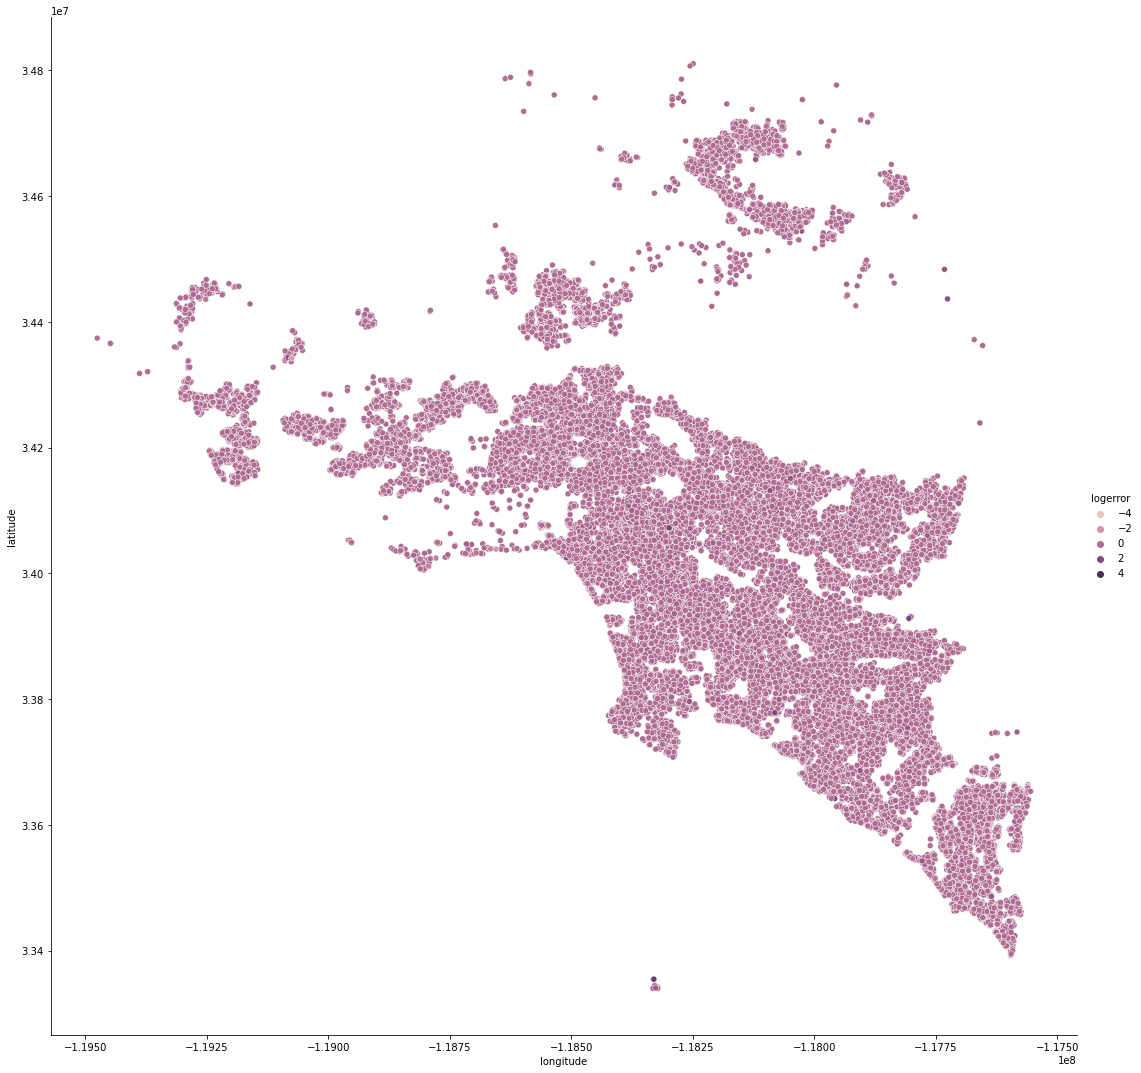

In [30]:
#plt.figure(figsize=(10,16))

sns.relplot(train.longitude, train.latitude, hue=train.logerror, height=15)

### Takeaway
* Initially I thought logerror would vary noticeably depending on the latitude and longitude. But, the logerror seems to be uniform all throughout the landscape.
* Maybe if I bin logerror I can get a better visualization.

In [31]:
# Create a bunch of bins for logerror to see if it will help with visualzing logerror when plotted on top of longitude vs latitude
train['logerror_bin'] = pd.cut(train.logerror, bins=np.arange(train.logerror.min(),train.logerror.max(),step=1.5))

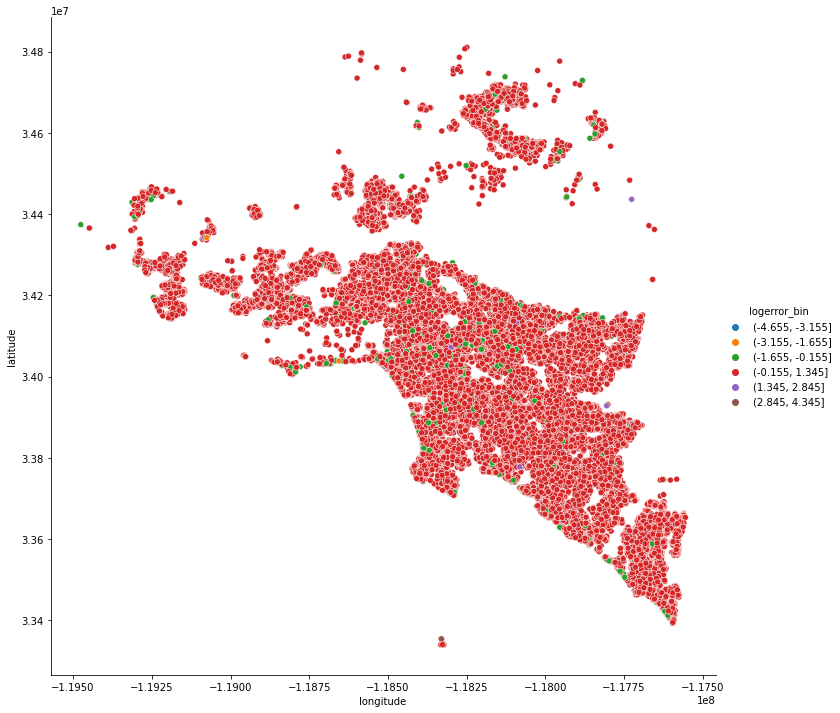

In [32]:
sns.relplot(train.longitude, train.latitude, hue=train.logerror_bin, height=10)

### Takeaways
* Binning the logerror made some of the observations stand out a little more, but I can't see any patterns as of now.

## Time to explore!

## Target Variable: logerror
#### What will all our features look like plotted against the target (and everything else)?

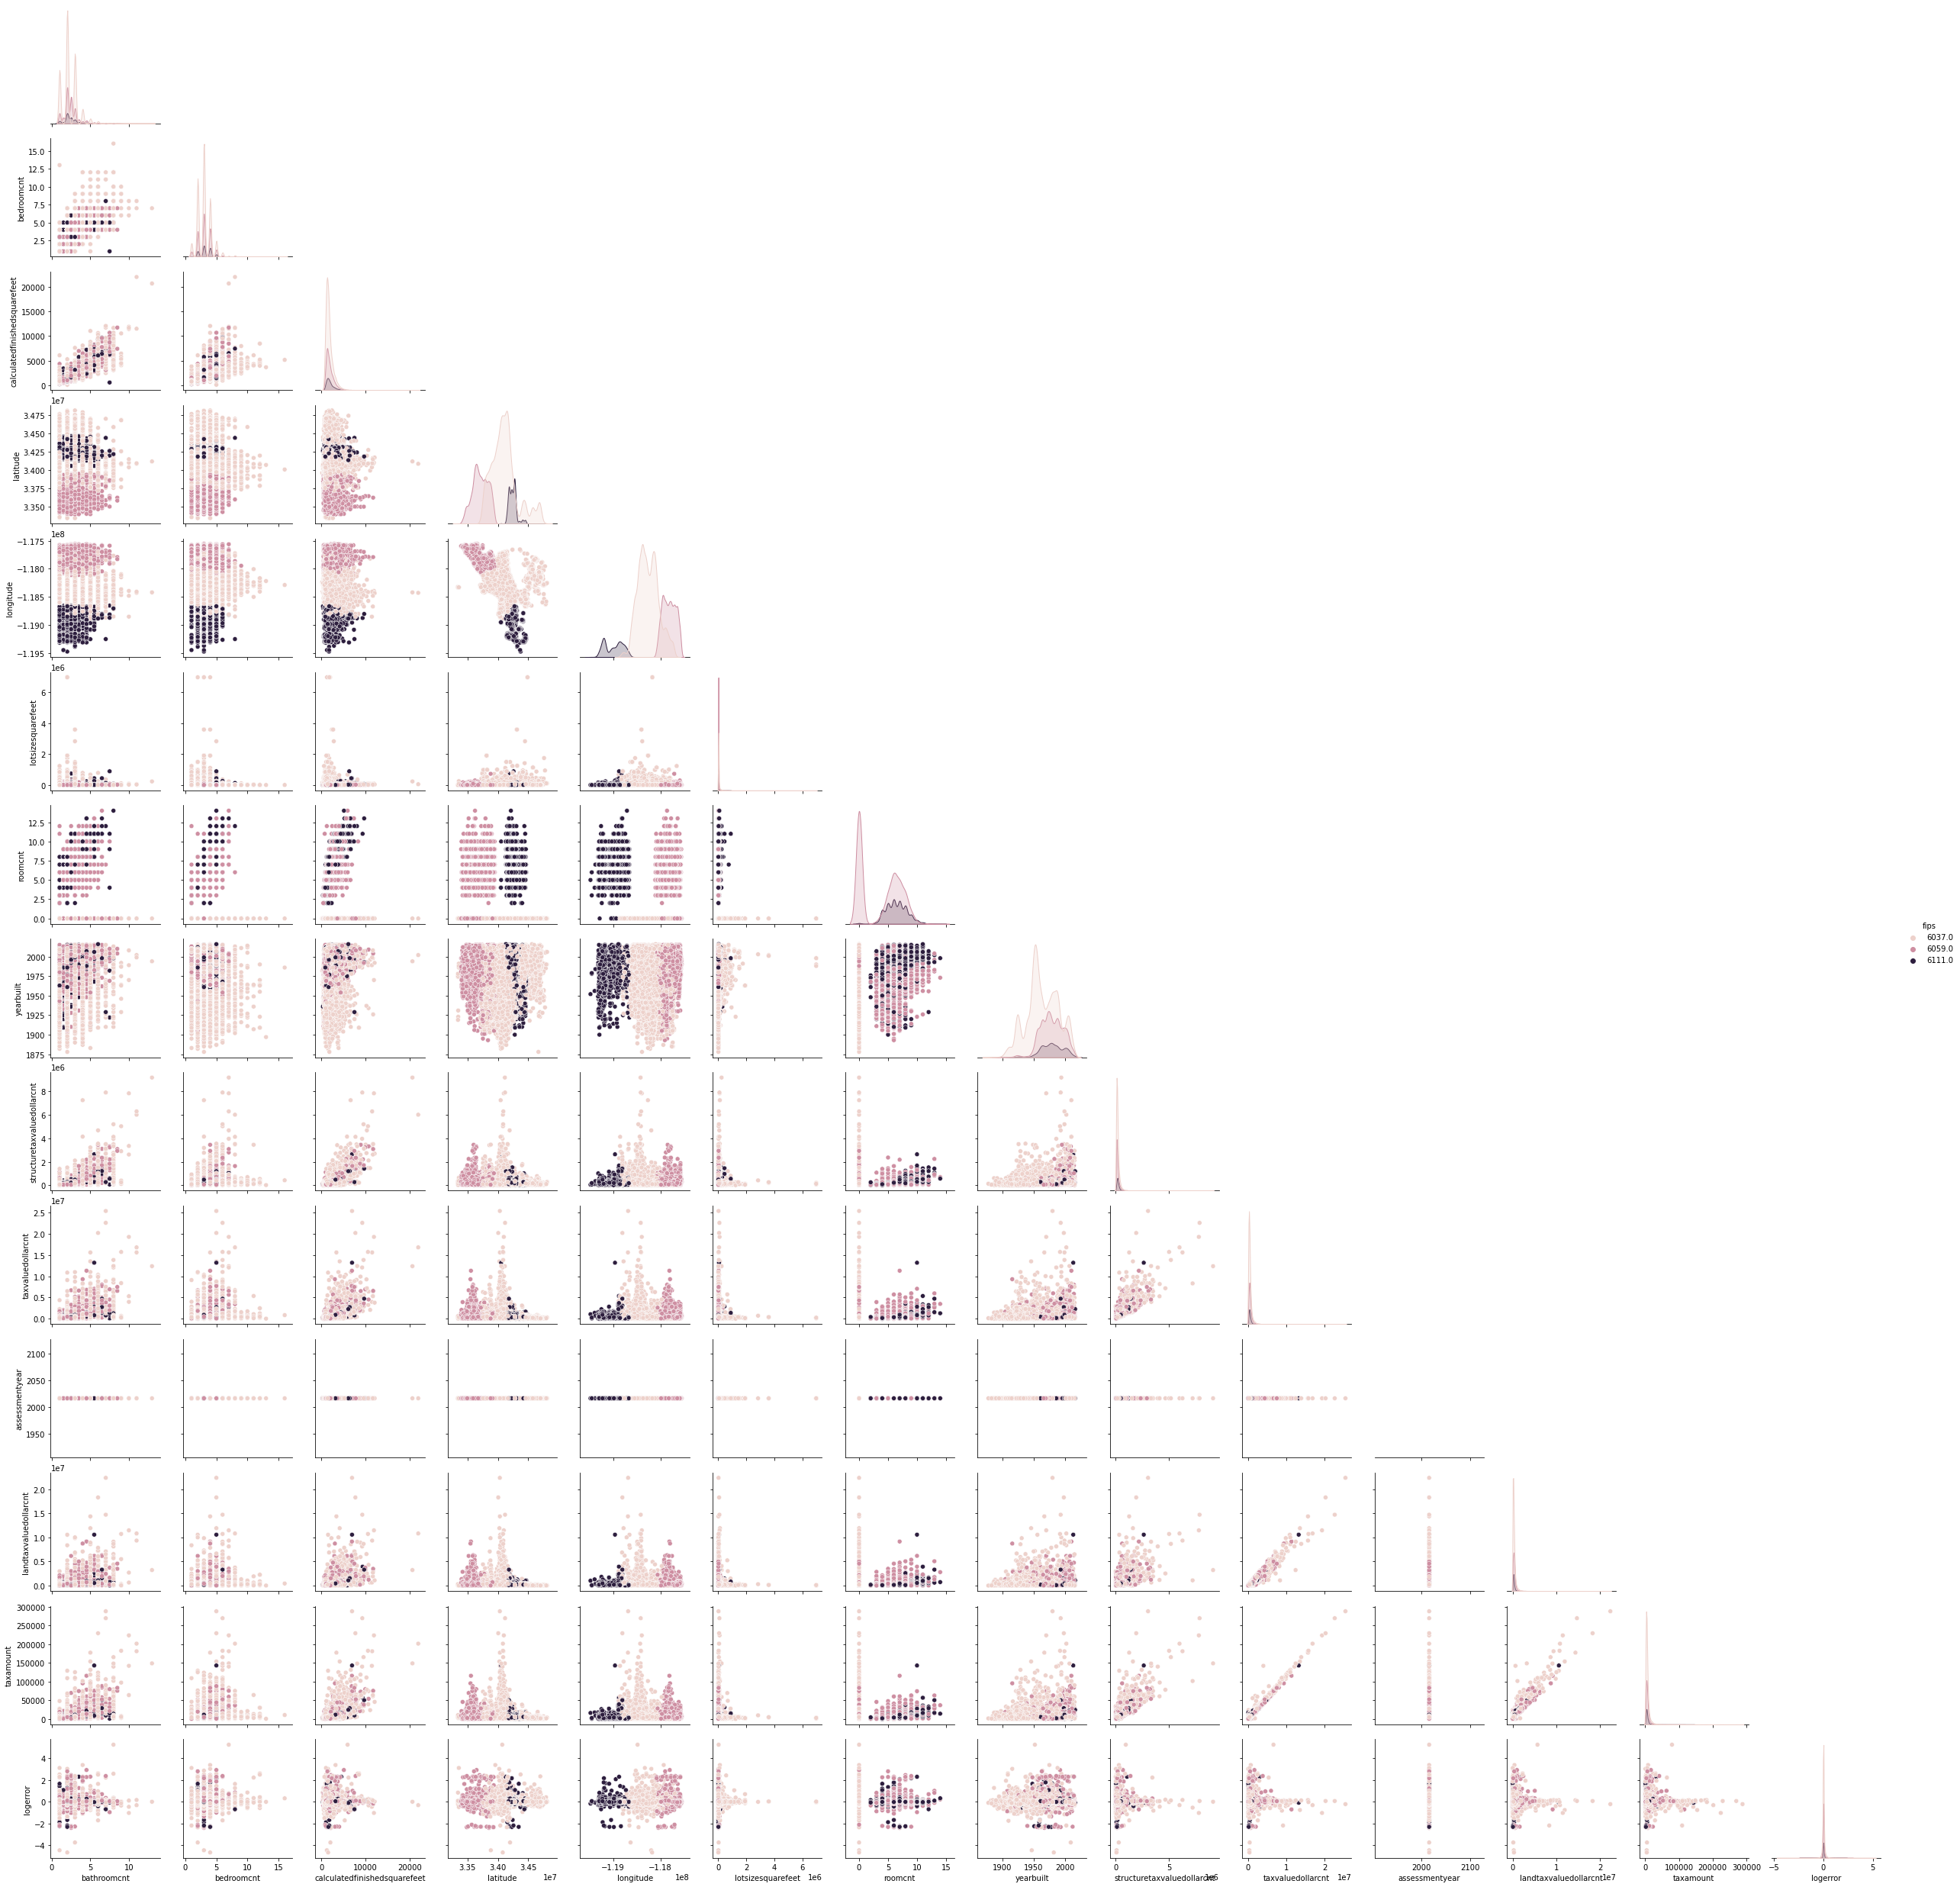

In [33]:
sns.pairplot(train, corner=True, hue='fips')

Text(0.5, 0, 'land_area')

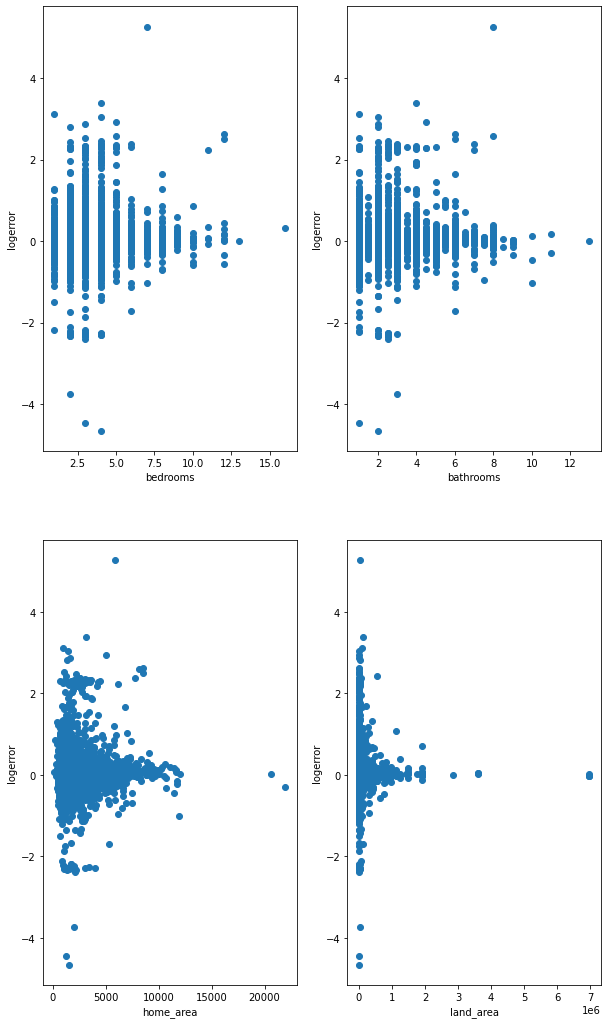

In [34]:
plt.figure(figsize=(10, 18))

plt.subplot(221)
plt.scatter(train.bedroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bedrooms')

plt.subplot(222)
plt.scatter(train.bathroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bathrooms')

plt.subplot(223)
plt.scatter(train.calculatedfinishedsquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('home_area')

plt.subplot(224)
plt.scatter(train.lotsizesquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('land_area')

## Takeaways

* There doesn't seem to be any linear trend when plotting the independent variable against our target.
* There is a large variance in logerror among the lower end of the sepctrum across all variables.
* Small land area seems to have higher logerror.

### Scale the data

In [35]:
# Create a scaler object using the MinMaxScaler
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler on the train dataset
# Use the select_dtypes to avoid an error when it tries to fit on the datetime datatype
scaler.fit(train.select_dtypes(include='float'))

# Use the scaler to transform the datasets
# Use the select_dtypes to avoid an error when it tries to transform on the datetime datatype
train_scaled = scaler.transform(train.select_dtypes(include='float'))
validate_scaled = scaler.transform(validate.select_dtypes(include='float'))
test_scaled = scaler.transform(test.select_dtypes(include='float'))

## Separate the target from the independent variables.

In [36]:
X_train = train.drop(columns=['logerror', 'logerror_bin'])
X_validate = validate.drop(columns='logerror')
X_test = test.drop(columns='logerror')

In [37]:
def Min_Max_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [38]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [39]:
y_train = train[['logerror']]
y_validate = validate[['logerror']]
y_test = test[['logerror']]

### Choose top five features

In [40]:
# Set the number of top features to present
k = 5

# Let's start with Select K Best
# Make the thing
kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=5)

# fit the thing
kbest.fit(X_train, y_train)

# use the thing, 
# get_support() produces an array of booleans, so we can filter out the column names that matter the most
kbest_features = X_train.columns[kbest.get_support()].tolist()

print("KBest's 5 best features are", kbest_features)

KBest's 5 best features are ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'longitude', 'roomcnt']


In [41]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=5)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [42]:
rfe_feature

['calculatedfinishedsquarefeet',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

### Set the baseline model

In [43]:
# 1. Predict logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

RMSE using Mean
Train/In-Sample:  0.16981 
Validate/Out-of-Sample:  0.16668
RMSE using Median
Train/In-Sample:  0.17005 
Validate/Out-of-Sample:  0.16713


### Try using a linear regression model (OLS)

In [44]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column since we added additional columns to y_train.
lm.fit(X_train[rfe_feature], y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train[rfe_feature])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate[rfe_feature])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1694753384800109 
Validation/Out-of-Sample:  0.1664740601937647


### Try using a LassoLars model

In [45]:
# create the model object
lars = LassoLars(alpha=1.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train[rfe_feature], y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train[rfe_feature])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate[rfe_feature])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.16981225147598503 
Validation/Out-of-Sample:  0.16668326891953264


In [46]:
y_train.head(-10)

,logerror,logerror_pred_mean,logerror_pred_median,logerror_pred_lm,logerror_pred_lars
45257,-0.307749,0.015392,0.006411,0.007959,0.015392
54021,-0.123643,0.015392,0.006411,0.002773,0.015392
71314,-0.002535,0.015392,0.006411,0.001414,0.015392
8173,-0.045101,0.015392,0.006411,0.011557,0.015392
20821,0.014981,0.015392,0.006411,0.001219,0.015392
...,...,...,...,...,...
9369,0.073176,0.015392,0.006411,0.009446,0.015392
66274,0.440944,0.015392,0.006411,0.017604,0.015392
33161,-0.053477,0.015392,0.006411,0.004164,0.015392
43073,-0.039885,0.015392,0.006411,0.013246,0.015392


In [47]:
# create the model object
glm = TweedieRegressor(power=2, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train[rfe_feature], y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train[rfe_feature])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate[rfe_feature])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

### Further exploration

#### What is the distribution of each of the variables?

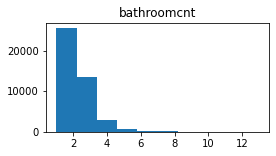

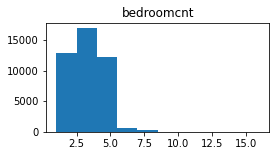

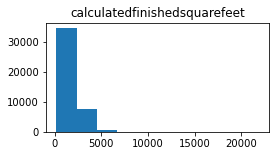

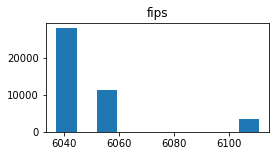

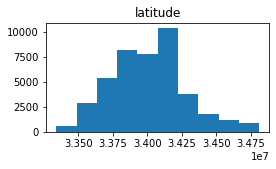

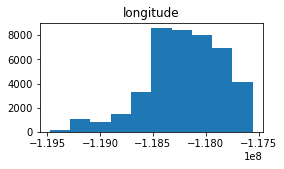

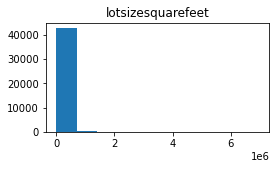

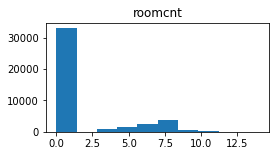

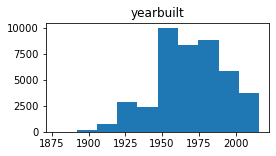

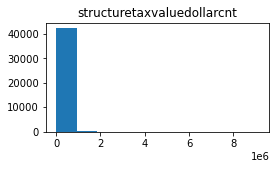

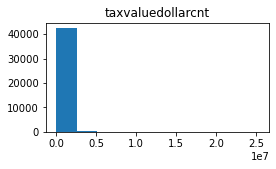

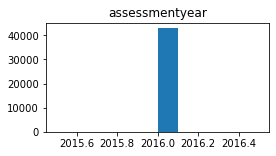

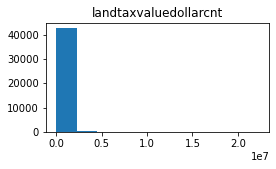

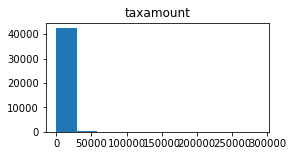

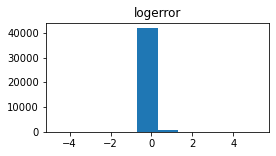

TypeError: '<=' not supported between instances of 'pandas._libs.interval.Interval' and 'float'

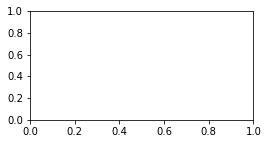

In [48]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

#### Does the mean logerror differ among the three counties?
LA_County = 6037

Orange_County = 6059

Ventura_County = 6111

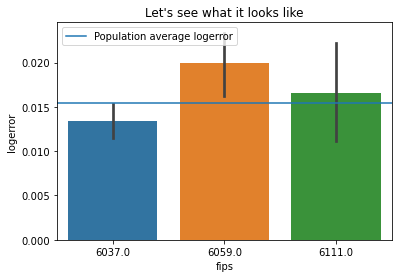

In [49]:
plt.title("Let's see what it looks like")
sns.barplot(x="fips", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

### Takeaway
* The mean logerror of Orange County is significantly higher than the population average.
* The mean logerror of Ventura County is slightly higher than the population average.
* The mean logerror of LA County is slightly lower than the population average.

#### Do older homes have a greater logerror than newer homes?
####     -> What if we control for county?

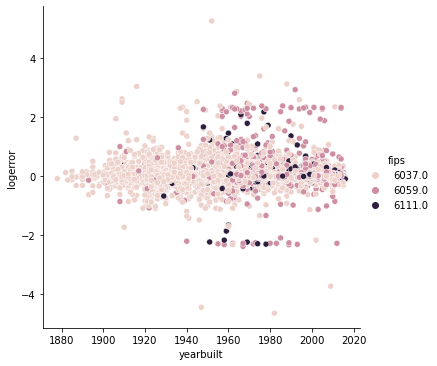

In [50]:
sns.relplot(train.yearbuilt, train.logerror, data=train, hue='fips')

### Takeaway
* It seems as if the variance in logerror increases for homes built after 1940.
* There seems to be 3 clusters. A middle cluster where most of the datapoints are situated, a top cluster, and a lower cluster.

## Speaking of clusters...

In [51]:
X_train

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount
45257,1.0,2.0,1148.0,6037.0,34119962.0,-118217185.0,6019.0,0.0,1922.0,110662.0,553311.0,2016.0,442649.0,6724.25
54021,2.0,2.0,898.0,6037.0,34113215.0,-118216168.0,6422.0,0.0,1947.0,150127.0,600517.0,2016.0,450390.0,7192.46
71314,1.0,1.0,1010.0,6037.0,34762455.0,-118274177.0,99411.0,0.0,1948.0,64420.0,88779.0,2016.0,24359.0,4153.06
8173,2.0,3.0,1218.0,6037.0,33984328.0,-118319988.0,4802.0,0.0,1923.0,66000.0,334000.0,2016.0,268000.0,4062.89
20821,1.0,1.0,835.0,6037.0,34410700.0,-118561000.0,842267.0,0.0,1989.0,141531.0,211532.0,2016.0,70001.0,3470.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,2.0,3.0,1054.0,6059.0,33673616.0,-117827506.0,5100.0,5.0,1969.0,73538.0,488770.0,2016.0,415232.0,5084.94
15118,3.0,4.0,2252.0,6037.0,34163340.0,-118483751.0,9179.0,0.0,1955.0,273029.0,700078.0,2016.0,427049.0,8534.24
54436,2.5,5.0,1992.0,6059.0,33879098.0,-117989539.0,2607.0,9.0,1966.0,50111.0,71680.0,2016.0,21569.0,1054.76
19528,3.0,2.0,1253.0,6037.0,34281150.0,-118577269.0,49231.9,0.0,2007.0,343693.0,491774.0,2016.0,148081.0,5945.66


In [59]:
# Create the KMeans object with three clusters.
kmeans = KMeans(n_clusters=3)

# Fit the KMeans object on the X_train values.
kmeans.fit(X_train)

# Use the KMeans object to predict the X_values and create a new column to store the values.
kmeans.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [62]:
X_train['cluster'] = kmeans.predict(X_train)

In [64]:
def create_scatter_plot(x,y,df,kmeans, X_scaled, scaler):
    
    """ Takes in x and y (variable names as strings, along with returned objects from previous
    function create_cluster and creates a plot"""
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = df, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

In [ ]:
create_scatter_plot(X_train.longitude, X_train.latitude, X_train, kmeans, )

In [68]:
def create_cluster(df, X, k):
    
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return dataframe (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe"""
    
    scaler = MinMaxScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    df['cluster'] = kmeans.predict(X_scaled)
    df['cluster'] = 'cluster_' + df.cluster.astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return df, X_scaled, scaler, kmeans, centroids

In [69]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X_train, 3)

NameError: name 'MinMaxScaler' is not defined